# Matrix generation

## Init symbols for *sympy*

In [1]:
from sympy import *
from geom_util import *
from sympy.vector import CoordSys3D
N = CoordSys3D('N')
alpha1, alpha2, alpha3 = symbols("alpha_1 alpha_2 alpha_3", real = True, positive=True)
init_printing()

%matplotlib inline

%reload_ext autoreload
%autoreload 2
%aimport geom_util

### Lame params

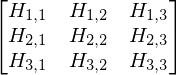

In [32]:
# h1 = Function("H1")
# h2 = Function("H2")
# h3 = Function("H3")

# H1 = h1(alpha1, alpha2, alpha3)
# H2 = h2(alpha1, alpha2, alpha3)
# H3 = h3(alpha1, alpha2, alpha3)

H1,H2,H3=symbols('H1,H2,H3')

H=[H1, H2, H3]
DIM=3
dH = zeros(DIM,DIM)
for i in range(DIM):
    for j in range(DIM):
        dH[i,j]=Symbol('H_{{{},{}}}'.format(i+1,j+1))

dH
    

### Metric tensor

${\displaystyle \hat{G}=\sum_{i,j} g^{ij}\vec{R}_i\vec{R}_j}$

In [3]:
G_up = getMetricTensorUpLame(H1, H2, H3)

${\displaystyle \hat{G}=\sum_{i,j} g_{ij}\vec{R}^i\vec{R}^j}$

In [4]:
G_down = getMetricTensorDownLame(H1, H2, H3)

### Christoffel symbols

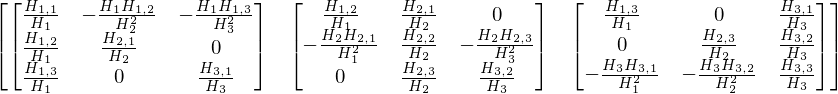

In [5]:
DIM=3

G_down_diff = MutableDenseNDimArray.zeros(DIM, DIM, DIM)
for i in range(DIM):
    for j in range(DIM):
        for k in range(DIM):
                
            G_down_diff[i,i,k]=2*H[i]*dH[i,k]
                

GK = getChristoffelSymbols2(G_up, G_down_diff, (alpha1, alpha2, alpha3))
GK

### Gradient of vector

$ 
\left( 
\begin{array}{c} 
\nabla_1 u_1 \\ \nabla_2 u_1 \\ \nabla_3 u_1 \\
\nabla_1 u_2 \\ \nabla_2 u_2 \\ \nabla_3 u_2 \\
\nabla_1 u_3 \\ \nabla_2 u_3 \\ \nabla_3 u_3 \\
\end{array} 
\right)
=  
B \cdot
\left( 
\begin{array}{c} 
u_1 \\
\frac { \partial u_1 } { \partial \alpha_1} \\
\frac { \partial u_1 } { \partial \alpha_2} \\
\frac { \partial u_1 } { \partial \alpha_3} \\
u_2 \\
\frac { \partial u_2 } { \partial \alpha_1} \\
\frac { \partial u_2 } { \partial \alpha_2} \\
\frac { \partial u_2 } { \partial \alpha_3} \\
u_3 \\
\frac { \partial u_3 } { \partial \alpha_1} \\
\frac { \partial u_3 } { \partial \alpha_2} \\
\frac { \partial u_3 } { \partial \alpha_3} \\
\end{array} 
\right) 
= B \cdot D \cdot
\left( 
\begin{array}{c} 
u^1 \\
\frac { \partial u^1 } { \partial \alpha_1} \\
\frac { \partial u^1 } { \partial \alpha_2} \\
\frac { \partial u^1 } { \partial \alpha_3} \\
u^2 \\
\frac { \partial u^2 } { \partial \alpha_1} \\
\frac { \partial u^2 } { \partial \alpha_2} \\
\frac { \partial u^2 } { \partial \alpha_3} \\
u^3 \\
\frac { \partial u^3 } { \partial \alpha_1} \\
\frac { \partial u^3 } { \partial \alpha_2} \\
\frac { \partial u^3 } { \partial \alpha_3} \\
\end{array} 
\right) 
$

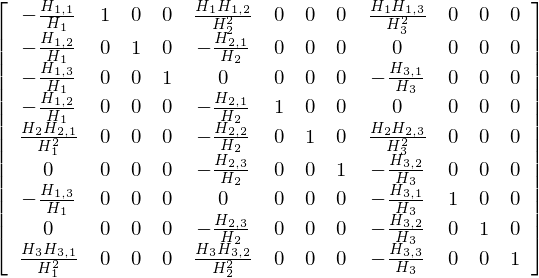

In [6]:
def row_index_to_i_j_grad(i_row):
    return i_row // 3, i_row % 3
        

B = zeros(9, 12)
B[0,1] = S(1)
B[1,2] = S(1)

B[2,3] = S(1)

B[3,5] = S(1)
B[4,6] = S(1)
B[5,7] = S(1)

B[6,9] = S(1)
B[7,10] = S(1)
B[8,11] = S(1)

for row_index in range(9):
    i,j=row_index_to_i_j_grad(row_index)
    B[row_index, 0] = -GK[i,j,0]
    B[row_index, 4] = -GK[i,j,1]
    B[row_index, 8] = -GK[i,j,2]

B

### Strain tensor

$ 
\left( 
\begin{array}{c} 
\varepsilon_{11} \\ 
\varepsilon_{22} \\ 
\varepsilon_{33} \\ 
2\varepsilon_{12} \\ 
2\varepsilon_{13} \\ 
2\varepsilon_{23} \\ 
\end{array} 
\right)
=  
\left(E + E_{NL} \left( \nabla \vec{u} \right) \right) \cdot 
\left( 
\begin{array}{c} 
\nabla_1 u_1 \\ \nabla_2 u_1 \\ \nabla_3 u_1 \\
\nabla_1 u_2 \\ \nabla_2 u_2 \\ \nabla_3 u_2 \\
\nabla_1 u_3 \\ \nabla_2 u_3 \\ \nabla_3 u_3 \\
\end{array} 
\right)$

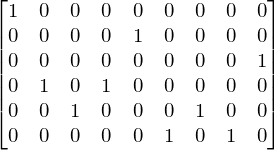

In [7]:
E=zeros(6,9)
E[0,0]=1
E[1,4]=1
E[2,8]=1
E[3,1]=1
E[3,3]=1
E[4,2]=1
E[4,6]=1
E[5,5]=1
E[5,7]=1
E

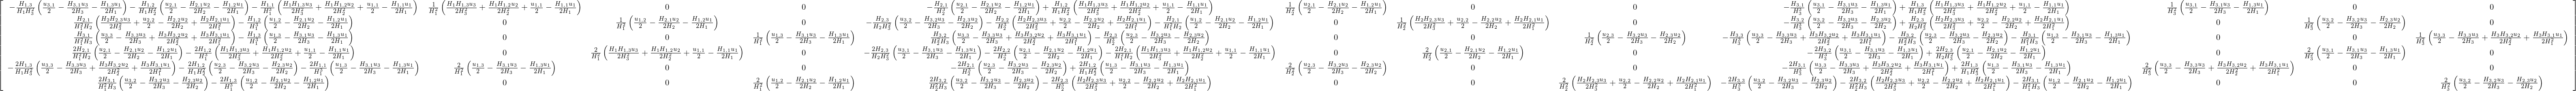

In [33]:
def E_NonLinear(grad_u):
    N = 3

    du = zeros(N, N)

    #    print("===Deformations===")

    for i in range(N):
        for j in range(N):
            index = i*N+j
            du[j,i] = grad_u[index]

    #    print("========")
    
    I = eye(3)

    a_values = S(1)/S(2) * du * G_up


    E_NL = zeros(6,9)
    E_NL[0,0] = a_values[0,0]
    E_NL[0,3] = a_values[0,1]
    E_NL[0,6] = a_values[0,2]

    E_NL[1,1] = a_values[1,0]
    E_NL[1,4] = a_values[1,1]
    E_NL[1,7] = a_values[1,2]

    E_NL[2,2] = a_values[2,0]
    E_NL[2,5] = a_values[2,1]
    E_NL[2,8] = a_values[2,2]

    E_NL[3,1] = 2*a_values[0,0]
    E_NL[3,4] = 2*a_values[0,1]
    E_NL[3,7] = 2*a_values[0,2]

    E_NL[4,0] = 2*a_values[2,0]
    E_NL[4,3] = 2*a_values[2,1]
    E_NL[4,6] = 2*a_values[2,2]

    E_NL[5,2] = 2*a_values[1,0]
    E_NL[5,5] = 2*a_values[1,1]
    E_NL[5,8] = 2*a_values[1,2]


    return E_NL


%aimport geom_util
u=getUHat3D(alpha1, alpha2, alpha3)


# u=getUHatU3Main(alpha1, alpha2, alpha3)

gradu=B*u


E_NL = E_NonLinear(gradu)*B

E_NL


### Physical coordinates

$u_i=u_{[i]} H_i$

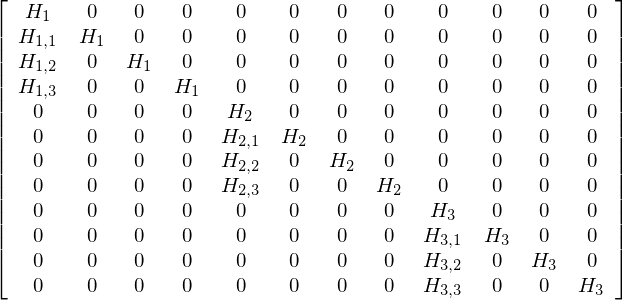

In [9]:
P=zeros(12,12)
P[0,0]=H[0]
P[1,0]=dH[0,0]
P[1,1]=H[0]
P[2,0]=dH[0,1]
P[2,2]=H[0]
P[3,0]=dH[0,2]
P[3,3]=H[0]

P[4,4]=H[1]
P[5,4]=dH[1,0]
P[5,5]=H[1]
P[6,4]=dH[1,1]
P[6,6]=H[1]
P[7,4]=dH[1,2]
P[7,7]=H[1]

P[8,8]=H[2]
P[9,8]=dH[2,0]
P[9,9]=H[2]
P[10,8]=dH[2,1]
P[10,10]=H[2]
P[11,8]=dH[2,2]
P[11,11]=H[2]
P=simplify(P)
P

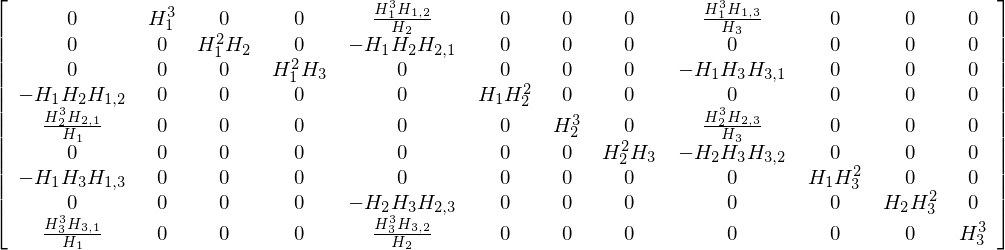

In [34]:
B_P = zeros(9,9)

for i in range(3):
    for j in range(3):
        
        row_index = i*3+j
        
        B_P[row_index, row_index] = H[i]*H[j]
        


Grad_U_P = simplify(B_P*B*P)
Grad_U_P

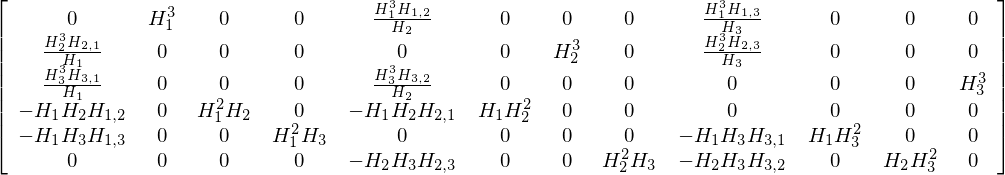

In [11]:
StrainL=simplify(E*Grad_U_P)
StrainL

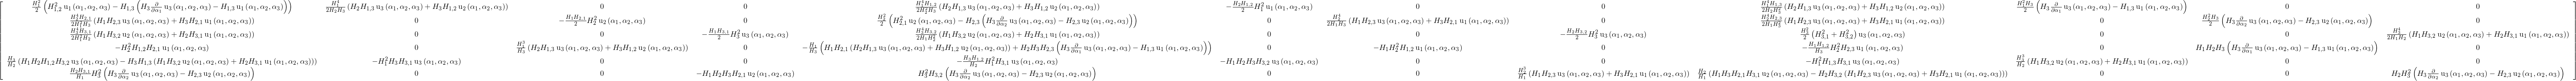

In [28]:
%aimport geom_util


u=getUHatU3Main(alpha1, alpha2, alpha3)

gradup=Grad_U_P*u


E_NLp = E_NonLinear(gradup)*Grad_U_P


simplify(E_NLp)

### Tymoshenko theory

$u_1 \left( \alpha_1, \alpha_2, \alpha_3 \right)=u\left( \alpha_1 \right)+\alpha_3\gamma \left( \alpha_1 \right) $

$u_2 \left( \alpha_1, \alpha_2, \alpha_3 \right)=0 $

$u_3 \left( \alpha_1, \alpha_2, \alpha_3 \right)=w\left( \alpha_1 \right) $

$ \left( 
\begin{array}{c} 
u_1 \\
\frac { \partial u_1 } { \partial \alpha_1} \\
\frac { \partial u_1 } { \partial \alpha_2} \\
\frac { \partial u_1 } { \partial \alpha_3} \\
u_2 \\
\frac { \partial u_2 } { \partial \alpha_1} \\
\frac { \partial u_2 } { \partial \alpha_2} \\
\frac { \partial u_2 } { \partial \alpha_3} \\
u_3 \\
\frac { \partial u_3 } { \partial \alpha_1} \\
\frac { \partial u_3 } { \partial \alpha_2} \\
\frac { \partial u_3 } { \partial \alpha_3} \\
\end{array} 
\right) = T \cdot 
\left( 
\begin{array}{c} 
u \\
\frac { \partial u } { \partial \alpha_1} \\
\gamma \\
\frac { \partial \gamma } { \partial \alpha_1} \\
w \\
\frac { \partial w } { \partial \alpha_1} \\
\end{array} 
\right) $

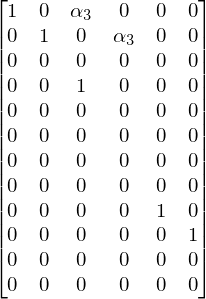

In [22]:
T=zeros(12,6)
T[0,0]=1
T[0,2]=alpha3
T[1,1]=1
T[1,3]=alpha3
T[3,2]=1

T[8,4]=1
T[9,5]=1
T

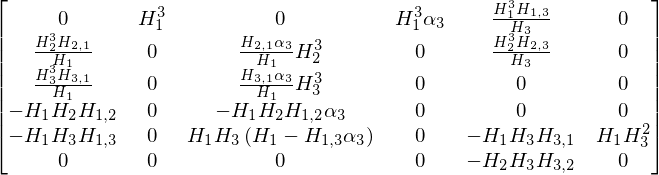

In [23]:
D_p_T = StrainL*T
simplify(D_p_T)

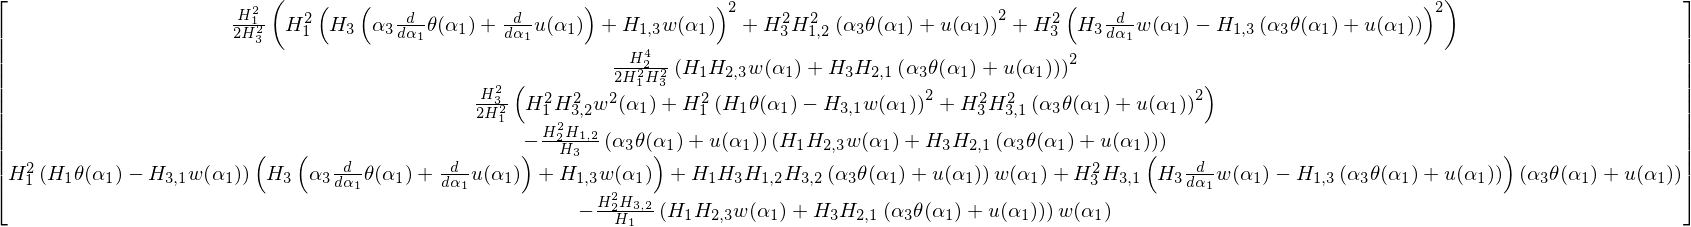

In [29]:
u = Function("u")
t = Function("theta")
w = Function("w")

u1=u(alpha1)+alpha3*t(alpha1)
u3=w(alpha1)

gu = zeros(12,1) 
gu[0] = u1
gu[1] = u1.diff(alpha1)
gu[3] = u1.diff(alpha3)


gu[8] = u3
gu[9] = u3.diff(alpha1)


gradup=Grad_U_P*gu

# o20=(K*u(alpha1)-w(alpha1).diff(alpha1)+t(alpha1))/2
# o21=K*t(alpha1)
# O=1/2*o20*o20+alpha3*o20*o21-alpha3*K/2*o20*o20
# O=expand(O)
# O=collect(O,alpha3)
# simplify(O)

StrainNL = E_NonLinear(gradup)*gradup
simplify(StrainNL)

### Square theory

$u^1 \left( \alpha_1, \alpha_2, \alpha_3 \right)=u_{10}\left( \alpha_1 \right)p_0\left( \alpha_3 \right)+u_{11}\left( \alpha_1 \right)p_1\left( \alpha_3 \right)+u_{12}\left( \alpha_1 \right)p_2\left( \alpha_3 \right) $

$u^2 \left( \alpha_1, \alpha_2, \alpha_3 \right)=0 $

$u^3 \left( \alpha_1, \alpha_2, \alpha_3 \right)=u_{30}\left( \alpha_1 \right)p_0\left( \alpha_3 \right)+u_{31}\left( \alpha_1 \right)p_1\left( \alpha_3 \right)+u_{32}\left( \alpha_1 \right)p_2\left( \alpha_3 \right) $

$ \left( 
\begin{array}{c} 
u^1 \\
\frac { \partial u^1 } { \partial \alpha_1} \\
\frac { \partial u^1 } { \partial \alpha_2} \\
\frac { \partial u^1 } { \partial \alpha_3} \\
u^2 \\
\frac { \partial u^2 } { \partial \alpha_1} \\
\frac { \partial u^2 } { \partial \alpha_2} \\
\frac { \partial u^2 } { \partial \alpha_3} \\
u^3 \\
\frac { \partial u^3 } { \partial \alpha_1} \\
\frac { \partial u^3 } { \partial \alpha_2} \\
\frac { \partial u^3 } { \partial \alpha_3} \\
\end{array} 
\right) = L \cdot 
\left( 
\begin{array}{c} 
u_{10} \\
\frac { \partial u_{10} } { \partial \alpha_1} \\
u_{11} \\
\frac { \partial u_{11} } { \partial \alpha_1} \\
u_{12} \\
\frac { \partial u_{12} } { \partial \alpha_1} \\
u_{30} \\
\frac { \partial u_{30} } { \partial \alpha_1} \\
u_{31} \\
\frac { \partial u_{31} } { \partial \alpha_1} \\
u_{32} \\
\frac { \partial u_{32} } { \partial \alpha_1} \\
\end{array} 
\right) $

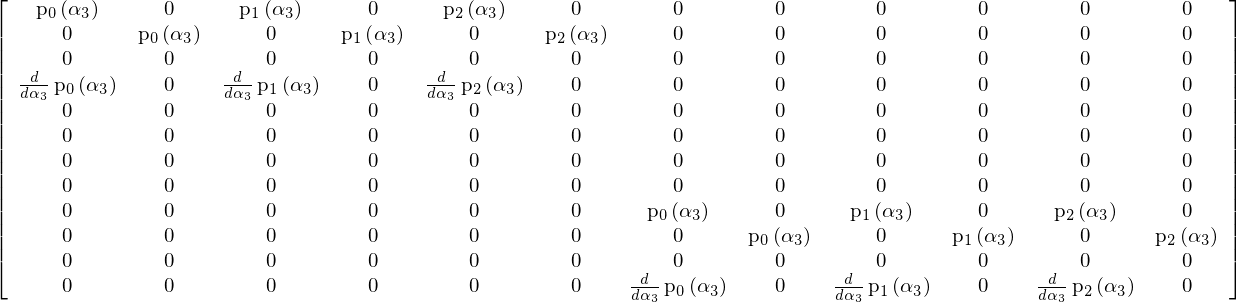

In [35]:
L=zeros(12,12)
h=Symbol('h')
# p0=1/2-alpha3/h
# p1=1/2+alpha3/h
# p2=1-(2*alpha3/h)**2

P0=Function('p_0')
P1=Function('p_1')
P2=Function('p_2')
# p1=1/2+alpha3/h
# p2=1-(2*alpha3/h)**2

p0=P0(alpha3)
p1=P1(alpha3)
p2=P2(alpha3)


L[0,0]=p0
L[0,2]=p1
L[0,4]=p2

L[1,1]=p0
L[1,3]=p1
L[1,5]=p2

L[3,0]=p0.diff(alpha3)
L[3,2]=p1.diff(alpha3)
L[3,4]=p2.diff(alpha3)

L[8,6]=p0
L[8,8]=p1
L[8,10]=p2

L[9,7]=p0
L[9,9]=p1
L[9,11]=p2

L[11,6]=p0.diff(alpha3)
L[11,8]=p1.diff(alpha3)
L[11,10]=p2.diff(alpha3)

L

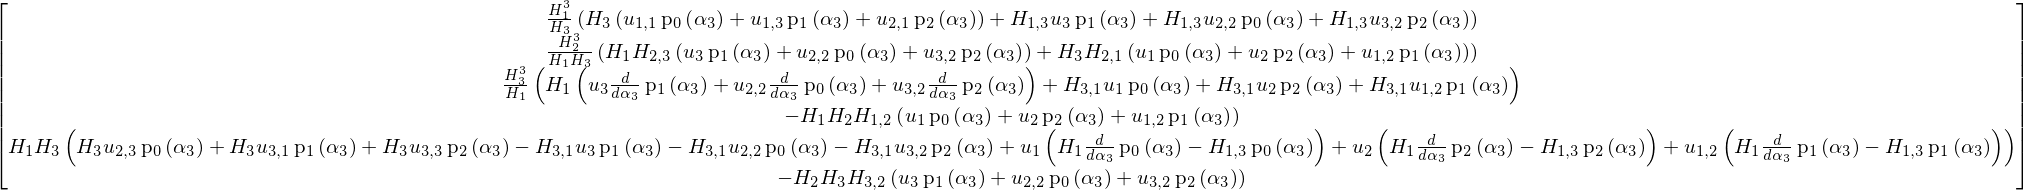

In [37]:
D_p_L = StrainL*L
simplify(D_p_L)

In [18]:
h = 0.5
exp=(0.5-alpha3/h)*(1-(2*alpha3/h)**2)#/(1+alpha3*0.8)
p02=integrate(exp, (alpha3, -h/2, h/2))
integral = expand(simplify(p02))
integral

## Mass matrix

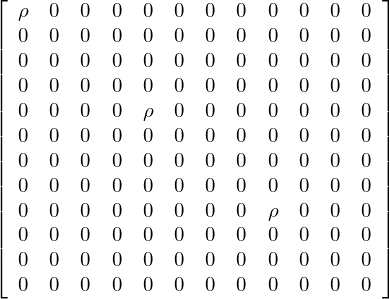

In [19]:
rho=Symbol('rho')
B_h=zeros(3,12)
B_h[0,0]=1
B_h[1,4]=1
B_h[2,8]=1
M=simplify(rho*P.T*B_h.T*G_up*B_h*P)
M

In [20]:
e1 = L.T*M*L/(1+alpha3*0.8)
e2 = L.T*M*L
e1r=integrate(e1, (alpha3, -thick/2, thick/2))
e2r=integrate(e2, (alpha3, -thick/2, thick/2))

NameError: name 'thick' is not defined

In [ ]:
thick=0.1
e1r.subs(h, thick)-e2r.subs(h, thick)